## Observed data, clustering with KMeans

In [ ]:
import numpy as np
import pandas as pd
import os
import cluster_data
import cluster_plotter
from cluster_data import run_clustering, normalize_data, unnormalize
from cluster_plotter import ClusterPlotter
from clustering_utils import ClusterData
from kmeans import k_means
import getdata

# Define observed files
uncorr_obs_files = {
    year: f"ogs{year}01_12_det.ele_ucorr" if year != 2002 else f"ogs{year}08_12_det.ele_ucorr"
    for year in range(2002, 2024) if year != 2018  # Exclude 2018 if missing
}

print(uncorr_obs_files)

standard_year_ranges = {f"{start}-{start + 3}": np.arange(start, start + 4) for start in [2002, 2006, 2010, 2014]}
standard_year_ranges["2019-2023"] = np.arange(2019, 2024)

running_ranges = cluster_data.generate_running_year_ranges(2002, 2023, 4)
year_ranges = running_ranges

# Bin the observed data
binned_data = cluster_data.bin_observed_data(uncorr_obs_files, year_ranges, print_res=False)

# Output directory for plots
plot_dir = "kmeans_observed_running_bins"
os.makedirs(plot_dir, exist_ok=True)
cluster_plotter.clear_directory(plot_dir)

for cluster_data, year_range in binned_data:
    print(f"\nRunning K-Means for Year Range: {year_range}")
    
    data_array = np.array([cluster_data.inc, cluster_data.raan]).T
    normalized_data, data_min, data_max = normalize_data(data_array)
    
    results = []
    for k in [3, 4, 5, 6, 7]:
        result_kmeans, time_kmeans, n_clusters_kmeans, points_per_cluster_kmeans, metrics_kmeans = run_clustering(
            k_means, "K-Means", normalized_data, data_min, data_max, k, plot=False
        )

        unnormalized_data, cluster_centers = unnormalize(result_kmeans.data, result_kmeans.cluster_centers, data_min, data_max)
        plotter = ClusterPlotter(unnormalized_data, result_kmeans.labels, cluster_centers)
        plotter.clusters_2d_plot(f"K-Means: years = {year_range}, k = {k}", os.path.join(plot_dir, f"kmeans_{year_range}_k{k}.png"))

        results.append({
            "Year Range": year_range, "k": k, "Runtime (s)": f"{time_kmeans:.3f}", "Clusters": n_clusters_kmeans,
            "Points per Cluster": points_per_cluster_kmeans,
            "Davies-Bouldin": f"{metrics_kmeans[0]:.3f}" if metrics_kmeans else None,
            "Calinski-Harabasz": f"{metrics_kmeans[1]:.3f}" if metrics_kmeans else None,
            "Dunn Index": f"{metrics_kmeans[2]:.3f}" if metrics_kmeans else None,
            "Silhouette Score": f"{metrics_kmeans[3]:.3f}" if metrics_kmeans else None
        })
    
    display(pd.DataFrame(results))

## Observed data, clustering with DBSCAN

In [ ]:
import numpy as np
import pandas as pd
import os
import cluster_data
import cluster_plotter
from cluster_data import run_clustering, normalize_data, unnormalize
from cluster_plotter import ClusterPlotter
from clustering_utils import ClusterData
from DBSCAN import dbscan_clustering  # Assuming you have a DBSCAN implementation
import getdata

# Define observed files
uncorr_obs_files = {
    year: f"ogs{year}01_12_det.ele_ucorr" if year != 2002 else f"ogs{year}08_12_det.ele_ucorr"
    for year in range(2002, 2024) if year != 2018  # Exclude 2018 if missing
}

print(uncorr_obs_files)

standard_year_ranges = {f"{start}-{start + 3}": np.arange(start, start + 4) for start in [2002, 2006, 2010, 2014]}
standard_year_ranges["2019-2023"] = np.arange(2019, 2024)

running_ranges = cluster_data.generate_running_year_ranges(2002, 2023, 4)
year_ranges = standard_year_ranges

# Bin the observed data
binned_data = cluster_data.bin_observed_data(uncorr_obs_files, year_ranges, print_res=False)

# Output directory for plots
plot_dir = "dbscan_observed_normal_bins"
os.makedirs(plot_dir, exist_ok=True)
cluster_plotter.clear_directory(plot_dir)

for cluster_data, year_range in binned_data:
    print(f"\nRunning DBSCAN for Year Range: {year_range}")
    
    data_array = np.array([cluster_data.inc, cluster_data.raan]).T
    normalized_data, data_min, data_max = normalize_data(data_array)
    
    results = []
    eps_values = [0.02, 0.01, 0.015, 0.05]
    min_samples_values = [10, 15, 20, 25]
    for eps in eps_values:
        for min_samples in min_samples_values:
            result_dbscan, time_dbscan, n_clusters_dbscan, points_per_cluster_dbscan, metrics_dbscan = run_clustering(
                dbscan_clustering, "DBSCAN", normalized_data, data_min, data_max, plot=False, eps=eps, min_samples=min_samples
            )

            unnormalized_data, cluster_centers = unnormalize(result_dbscan.data, result_dbscan.cluster_centers, data_min, data_max)
            plotter = ClusterPlotter(unnormalized_data, result_dbscan.labels, cluster_centers)
            plotter.clusters_2d_plot(
                f"DBSCAN: years = {year_range}, eps = {eps}, min_samples = {min_samples}",
                os.path.join(plot_dir, f"dbscan_{year_range}_eps{eps}_min{min_samples}.png")
            )

            results.append({
                "Year Range": year_range, "eps": eps, "min_samples": min_samples, "Runtime (s)": f"{time_dbscan:.3f}",
                "Clusters": n_clusters_dbscan, "Points per Cluster": points_per_cluster_dbscan,
                "Davies-Bouldin": f"{metrics_dbscan[0]:.3f}" if metrics_dbscan else None,
                "Calinski-Harabasz": f"{metrics_dbscan[1]:.3f}" if metrics_dbscan else None,
                "Dunn Index": f"{metrics_dbscan[2]:.3f}" if metrics_dbscan else None,
                "Silhouette Score": f"{metrics_dbscan[3]:.3f}" if metrics_dbscan else None
            })
    
    display(pd.DataFrame(results))


## Observed data, clustering with DBSCAN with GridSearch

In [ ]:
import cluster_data
from cluster_data import run_clustering, normalize_data, unnormalize
import numpy as np
import pandas as pd
import os
import cluster_plotter
from DBSCAN import dbscan_clustering
from cluster_plotter import ClusterPlotter
from clustering_utils import ClusterData

uncorr_obs_files = {
    year: f"ogs{year}01_12_det.ele_ucorr" if year != 2002 else f"ogs{year}08_12_det.ele_ucorr"
    for year in range(2002, 2024) if year != 2018  # Exclude 2018 if missing
}

print(uncorr_obs_files)

standard_year_ranges = {f"{start}-{start + 3}": np.arange(start, start + 4) for start in [2002, 2006, 2010, 2014]}
standard_year_ranges["2019-2023"] = np.arange(2019, 2024)

running_ranges = cluster_data.generate_running_year_ranges(2002, 2023, 4)
year_ranges = standard_year_ranges

# Bin the observed data
binned_data = cluster_data.bin_observed_data(uncorr_obs_files, year_ranges, print_res=False)

plot_dir = "dbscan_grid_search_normal_bins_observed"
os.makedirs(plot_dir, exist_ok=True)
cluster_plotter.clear_directory(plot_dir)

results_per_year_range = {}

for cluster_data, year_range in binned_data:  
    print(f"\nRunning DBSCAN for Year Range: {year_range}")

    data_array = np.array([cluster_data.inc, cluster_data.raan]).T
    normalized_data, data_min, data_max = normalize_data(data_array)

    # DBSCAN parameter grid
    eps_values = [0.01, 0.012, 0.015, 0.018, 0.02, 0.023, 0.05]
    min_samples_values = [7, 10, 15, 20, 30]
    
    best_result = None
    best_score = float('-inf')
    
    for eps in eps_values:
        for min_samples in min_samples_values:
            result_dbscan, time_dbscan, n_clusters_dbscan, points_per_cluster_dbscan, metrics_dbscan = run_clustering(
                dbscan_clustering, "DBSCAN", normalized_data, data_min, data_max, plot=False, eps=eps, min_samples=min_samples
            )
            
            silhouette_score = metrics_dbscan[3] if metrics_dbscan and isinstance(metrics_dbscan[3], (int, float)) else None
            noise_points = np.sum(result_dbscan.labels == -1)

            if silhouette_score is not None and silhouette_score > best_score:
                best_score = silhouette_score
                best_result = {
                    "eps": eps,
                    "min_samples": min_samples,
                    "runtime": time_dbscan,
                    "clusters": n_clusters_dbscan,
                    "points_per_cluster": points_per_cluster_dbscan,
                    "noise_points": noise_points,
                    "metrics": metrics_dbscan,
                    "result_dbscan": result_dbscan
                }

    # Plot and store only the best result
    if best_result:
        unnormalized_data, _ = unnormalize(best_result["result_dbscan"].data, None, data_min, data_max)
        plotter = ClusterPlotter(unnormalized_data, best_result["result_dbscan"].labels, None)
        plot_filename = os.path.join(plot_dir, f"dbscan_{year_range}_best.png")
        title = f"DBSCAN Best: {year_range}, eps = {best_result['eps']}, min_samples = {best_result['min_samples']}"
        plotter.clusters_2d_plot(title, plot_filename, show_centers=False)
        
        results_per_year_range[year_range] = best_result
        
        print(f"Best for {year_range}: eps = {best_result['eps']}, min_samples = {best_result['min_samples']}, silhouette = {best_score:.3f}")

final_results = [
    {"Year Range": yr, "Eps": res["eps"], "Min Samples": res["min_samples"], "Silhouette Score": f"{res['metrics'][3]:.3f}", "Noise Points": res["noise_points"]}
    for yr, res in results_per_year_range.items()
]
df = pd.DataFrame(final_results)
display(df)

## Observed data, clustering with OPTICS

{2002: 'ogs200208_12_det.ele_ucorr', 2003: 'ogs200301_12_det.ele_ucorr', 2004: 'ogs200401_12_det.ele_ucorr', 2005: 'ogs200501_12_det.ele_ucorr', 2006: 'ogs200601_12_det.ele_ucorr', 2007: 'ogs200701_12_det.ele_ucorr', 2008: 'ogs200801_12_det.ele_ucorr', 2009: 'ogs200901_12_det.ele_ucorr', 2010: 'ogs201001_12_det.ele_ucorr', 2011: 'ogs201101_12_det.ele_ucorr', 2012: 'ogs201201_12_det.ele_ucorr', 2013: 'ogs201301_12_det.ele_ucorr', 2014: 'ogs201401_12_det.ele_ucorr', 2015: 'ogs201501_12_det.ele_ucorr', 2016: 'ogs201601_12_det.ele_ucorr', 2017: 'ogs201701_12_det.ele_ucorr', 2019: 'ogs201901_12_det.ele_ucorr', 2020: 'ogs202001_12_det.ele_ucorr', 2021: 'ogs202101_12_det.ele_ucorr', 2022: 'ogs202201_12_det.ele_ucorr', 2023: 'ogs202301_12_det.ele_ucorr'}

Running OPTICS for Year Range: 2002-2005


Running OPTICS:   0%|          | 0/3 [00:00<?, ?step/s]

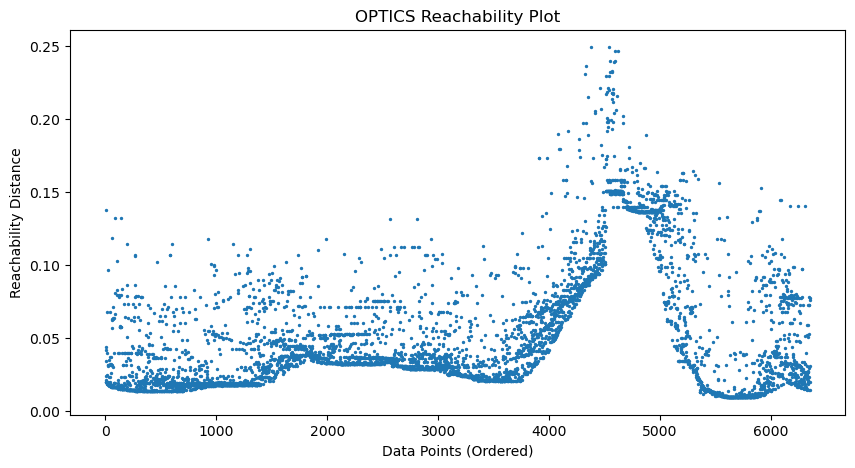

Runtime for optics_clustering: 6.352764 seconds


Running OPTICS:   0%|          | 0/3 [00:07<?, ?step/s]


Plot saved as: Images/optics_observations_normal_bins\optics_2002-2005_min200_maxeps1000_xi0.001.png
(7,)


Running OPTICS:   0%|          | 0/3 [00:00<?, ?step/s]

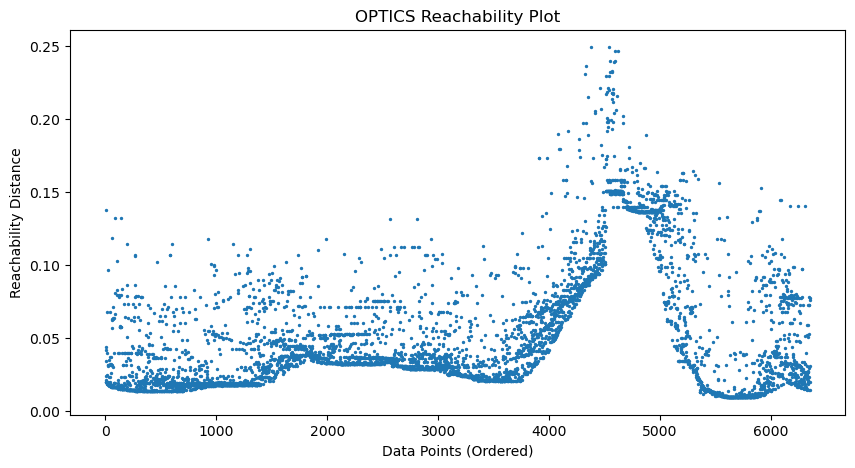

Runtime for optics_clustering: 6.581019 seconds


Running OPTICS:   0%|          | 0/3 [00:07<?, ?step/s]


Plot saved as: Images/optics_observations_normal_bins\optics_2002-2005_min200_maxeps1000_xi0.002.png
(7,)


Running OPTICS:   0%|          | 0/3 [00:00<?, ?step/s]

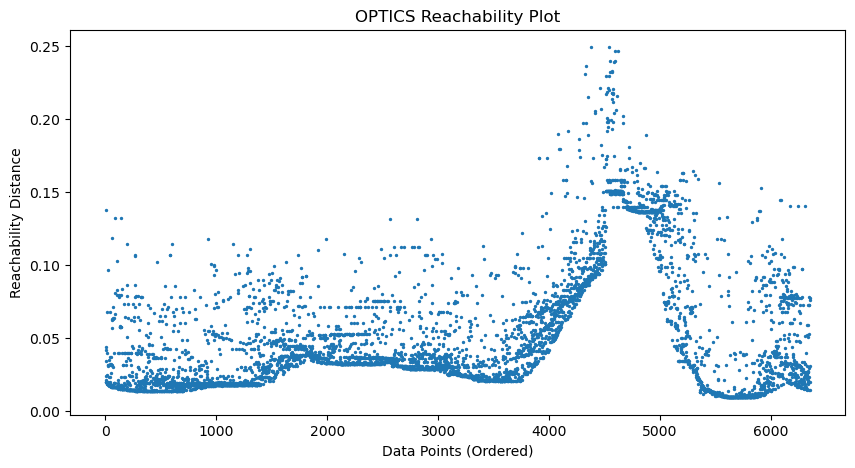

Runtime for optics_clustering: 5.239704 seconds


Running OPTICS:   0%|          | 0/3 [00:06<?, ?step/s]


Plot saved as: Images/optics_observations_normal_bins\optics_2002-2005_min200_maxepsinf_xi0.001.png
(7,)


Running OPTICS:   0%|          | 0/3 [00:00<?, ?step/s]

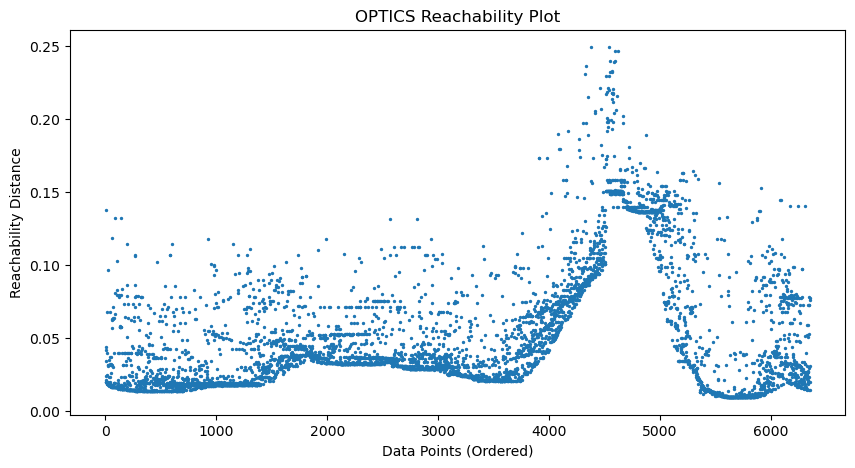

Runtime for optics_clustering: 10.083796 seconds


Running OPTICS:   0%|          | 0/3 [00:11<?, ?step/s]


Plot saved as: Images/optics_observations_normal_bins\optics_2002-2005_min200_maxepsinf_xi0.002.png
(7,)


Running OPTICS:   0%|          | 0/3 [00:00<?, ?step/s]

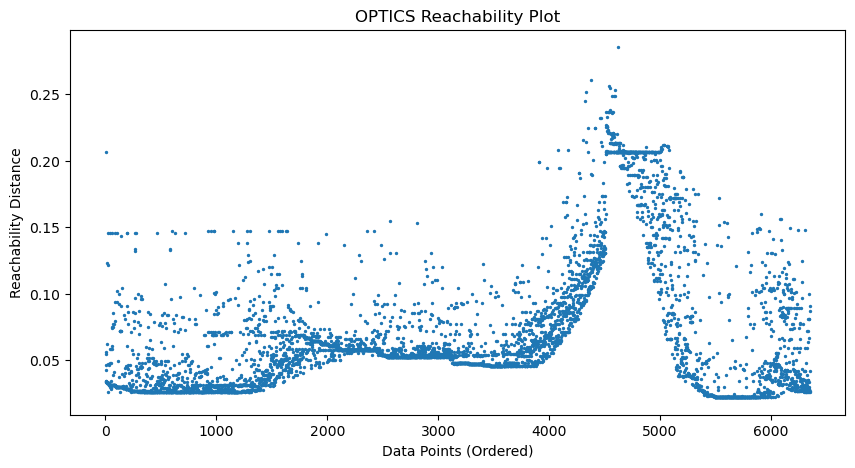

Runtime for optics_clustering: 7.031440 seconds


Running OPTICS:   0%|          | 0/3 [00:08<?, ?step/s]


Plot saved as: Images/optics_observations_normal_bins\optics_2002-2005_min400_maxeps1000_xi0.001.png
(7,)


Running OPTICS:   0%|          | 0/3 [00:00<?, ?step/s]

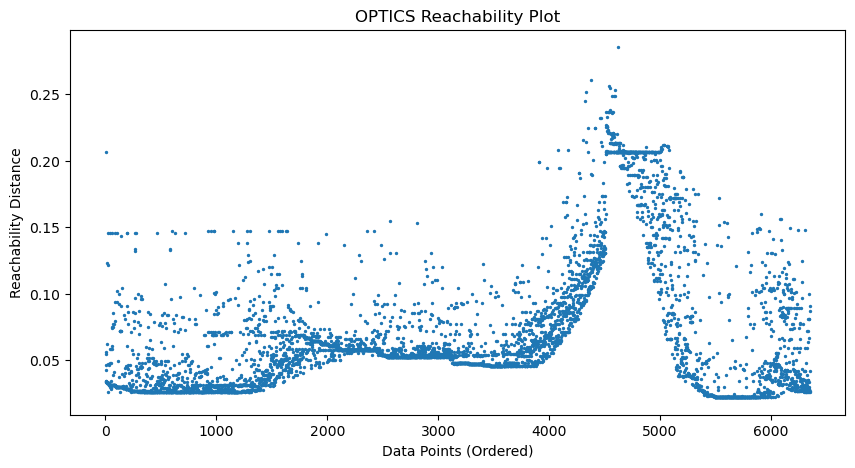

Runtime for optics_clustering: 6.716539 seconds


Running OPTICS:   0%|          | 0/3 [00:07<?, ?step/s]


Plot saved as: Images/optics_observations_normal_bins\optics_2002-2005_min400_maxeps1000_xi0.002.png
(7,)


Running OPTICS:   0%|          | 0/3 [00:00<?, ?step/s]

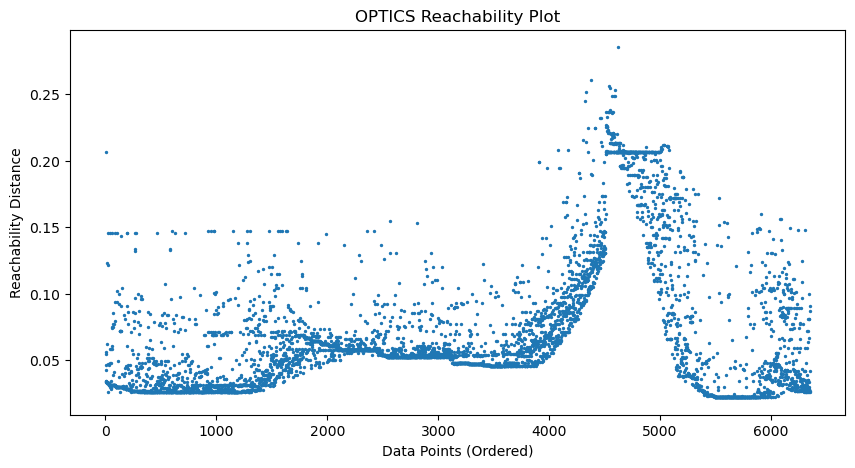

Runtime for optics_clustering: 7.105414 seconds


Running OPTICS:   0%|          | 0/3 [00:07<?, ?step/s]


Plot saved as: Images/optics_observations_normal_bins\optics_2002-2005_min400_maxepsinf_xi0.001.png
(7,)


Running OPTICS:   0%|          | 0/3 [00:00<?, ?step/s]

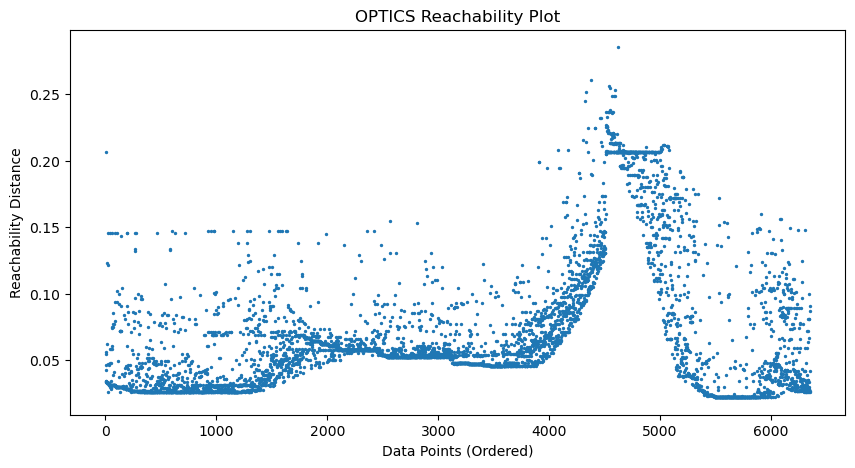

Runtime for optics_clustering: 5.444424 seconds


Running OPTICS:   0%|          | 0/3 [00:06<?, ?step/s]


Plot saved as: Images/optics_observations_normal_bins\optics_2002-2005_min400_maxepsinf_xi0.002.png
(7,)


Running OPTICS:   0%|          | 0/3 [00:00<?, ?step/s]

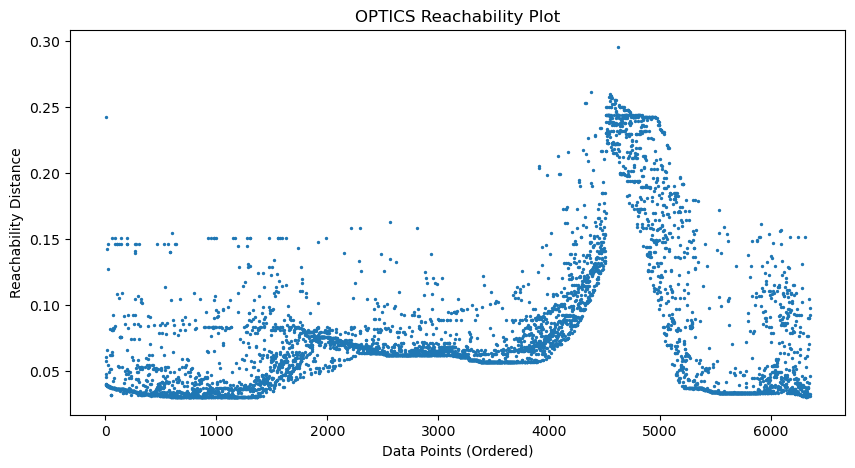

Runtime for optics_clustering: 6.682341 seconds


Running OPTICS:   0%|          | 0/3 [00:08<?, ?step/s]


Plot saved as: Images/optics_observations_normal_bins\optics_2002-2005_min500_maxeps1000_xi0.001.png
(7,)


Running OPTICS:   0%|          | 0/3 [00:00<?, ?step/s]

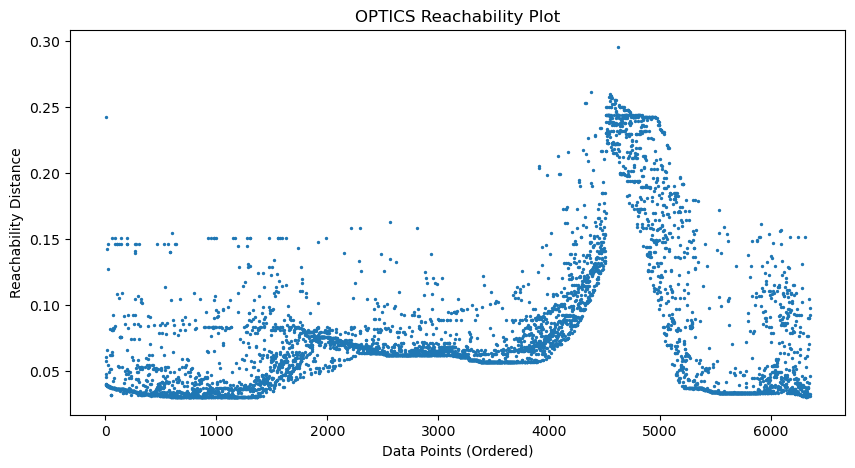

Runtime for optics_clustering: 17.169899 seconds


Running OPTICS:   0%|          | 0/3 [00:20<?, ?step/s]


Plot saved as: Images/optics_observations_normal_bins\optics_2002-2005_min500_maxeps1000_xi0.002.png
(7,)


Running OPTICS:   0%|          | 0/3 [00:00<?, ?step/s]

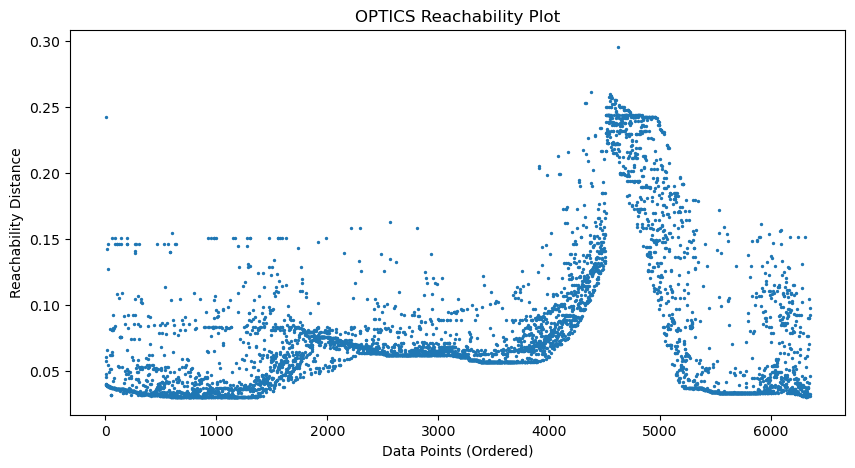

Runtime for optics_clustering: 19.896170 seconds


Running OPTICS:   0%|          | 0/3 [00:23<?, ?step/s]


Plot saved as: Images/optics_observations_normal_bins\optics_2002-2005_min500_maxepsinf_xi0.001.png
(7,)


Running OPTICS:   0%|          | 0/3 [00:00<?, ?step/s]

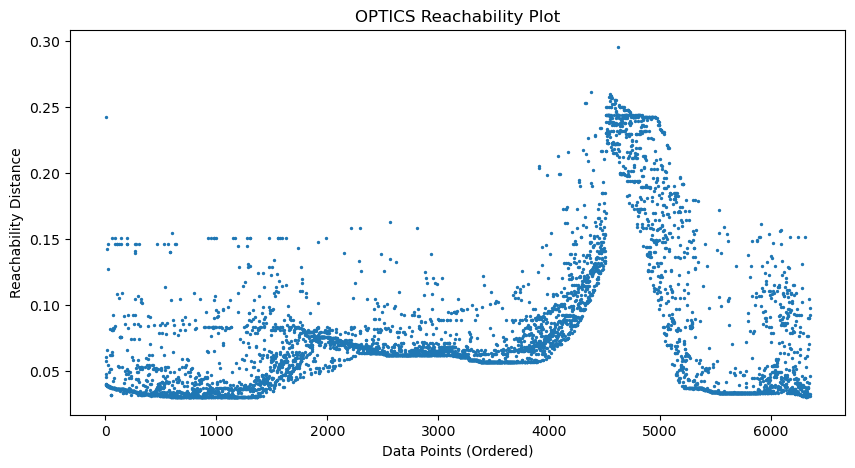

Runtime for optics_clustering: 19.041782 seconds


Running OPTICS:   0%|          | 0/3 [00:20<?, ?step/s]


Plot saved as: Images/optics_observations_normal_bins\optics_2002-2005_min500_maxepsinf_xi0.002.png
(7,)


,Year Range,k,Runtime (s),Clusters,Points per Cluster,Davies-Bouldin,Calinski-Harabasz,Dunn Index,Silhouette Score,Cluster Std.,Square Density,Hull Density
0,2002-2005,8,6.353,8,"{0: 393, 1: 476, 2: 560, 3: 453, 4: 210, 5: 65...",1.800,705.940,0.000,-0.030,"{-1: (0.164, 0.252), 0: (0.017, 0.036), 1: (0....","{-1: 3260.1, 0: 37355.663, 1: 26504.175, 2: 27...","{-1: 3620.434, 0: 46284.081, 1: 38889.995, 2: ..."
1,2002-2005,8,6.581,8,"{0: 393, 1: 476, 2: 560, 3: 453, 4: 210, 5: 65...",1.800,705.940,0.000,-0.030,"{-1: (0.164, 0.252), 0: (0.017, 0.036), 1: (0....","{-1: 3260.1, 0: 37355.663, 1: 26504.175, 2: 27...","{-1: 3620.434, 0: 46284.081, 1: 38889.995, 2: ..."
2,2002-2005,8,5.240,8,"{0: 393, 1: 476, 2: 560, 3: 453, 4: 210, 5: 65...",1.800,705.940,0.000,-0.030,"{-1: (0.164, 0.252), 0: (0.017, 0.036), 1: (0....","{-1: 3260.1, 0: 37355.663, 1: 26504.175, 2: 27...","{-1: 3620.434, 0: 46284.081, 1: 38889.995, 2: ..."
3,2002-2005,8,10.084,8,"{0: 393, 1: 476, 2: 560, 3: 453, 4: 210, 5: 65...",1.800,705.940,0.000,-0.030,"{-1: (0.164, 0.252), 0: (0.017, 0.036), 1: (0....","{-1: 3260.1, 0: 37355.663, 1: 26504.175, 2: 27...","{-1: 3620.434, 0: 46284.081, 1: 38889.995, 2: ..."
4,2002-2005,5,7.031,5,"{0: 1580, 1: 663, 2: 906, 3: 607, -1: 2596}",1.983,804.361,0.000,0.133,"{-1: (0.25, 0.268), 0: (0.027, 0.054), 1: (0.0...","{-1: 2596.0, 0: 36837.427, 1: 23793.403, 2: 19...","{-1: 2662.492, 0: 46716.16, 1: 35822.419, 2: 2..."
5,2002-2005,5,6.717,5,"{0: 1580, 1: 663, 2: 906, 3: 607, -1: 2596}",1.983,804.361,0.000,0.133,"{-1: (0.25, 0.268), 0: (0.027, 0.054), 1: (0.0...","{-1: 2596.0, 0: 36837.427, 1: 23793.403, 2: 19...","{-1: 2662.492, 0: 46716.16, 1: 35822.419, 2: 2..."
6,2002-2005,5,7.105,5,"{0: 1580, 1: 663, 2: 906, 3: 607, -1: 2596}",1.983,804.361,0.000,0.133,"{-1: (0.25, 0.268), 0: (0.027, 0.054), 1: (0.0...","{-1: 2596.0, 0: 36837.427, 1: 23793.403, 2: 19...","{-1: 2662.492, 0: 46716.16, 1: 35822.419, 2: 2..."
7,2002-2005,5,5.444,5,"{0: 1580, 1: 663, 2: 906, 3: 607, -1: 2596}",1.983,804.361,0.000,0.133,"{-1: (0.25, 0.268), 0: (0.027, 0.054), 1: (0.0...","{-1: 2596.0, 0: 36837.427, 1: 23793.403, 2: 19...","{-1: 2662.492, 0: 46716.16, 1: 35822.419, 2: 2..."
8,2002-2005,5,6.682,5,"{0: 1571, 1: 671, 2: 730, 3: 579, -1: 2801}",1.805,796.953,0.000,0.105,"{-1: (0.242, 0.258), 0: (0.028, 0.053), 1: (0....","{-1: 2801.0, 0: 33882.077, 1: 23066.642, 2: 21...","{-1: 2872.743, 0: 44667.352, 1: 34154.123, 2: ..."
9,2002-2005,5,17.170,5,"{0: 1571, 1: 671, 2: 724, 3: 579, -1: 2807}",1.809,794.968,0.000,0.105,"{-1: (0.242, 0.258), 0: (0.028, 0.053), 1: (0....","{-1: 2807.0, 0: 33882.077, 1: 23066.642, 2: 22...","{-1: 2878.897, 0: 44667.352, 1: 34154.123, 2: ..."



Running OPTICS for Year Range: 2006-2009


Running OPTICS:   0%|          | 0/3 [00:00<?, ?step/s]

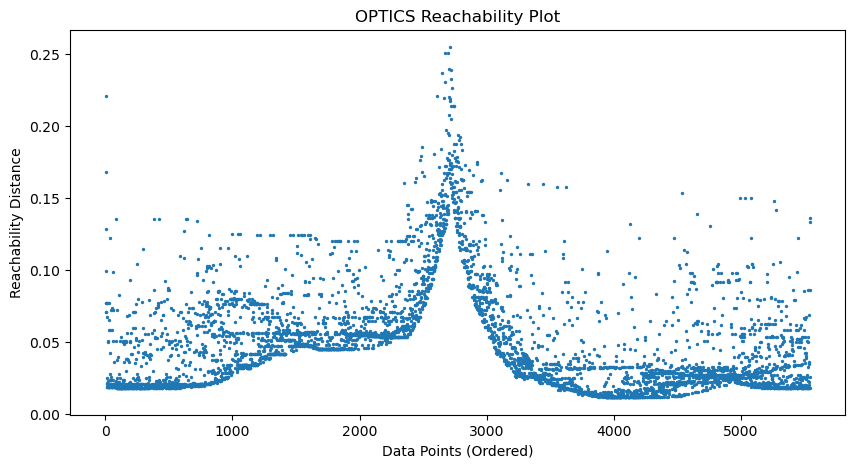

Runtime for optics_clustering: 10.135615 seconds


Running OPTICS:   0%|          | 0/3 [00:12<?, ?step/s]


Plot saved as: Images/optics_observations_normal_bins\optics_2006-2009_min200_maxeps1000_xi0.001.png
(7,)


Running OPTICS:   0%|          | 0/3 [00:00<?, ?step/s]

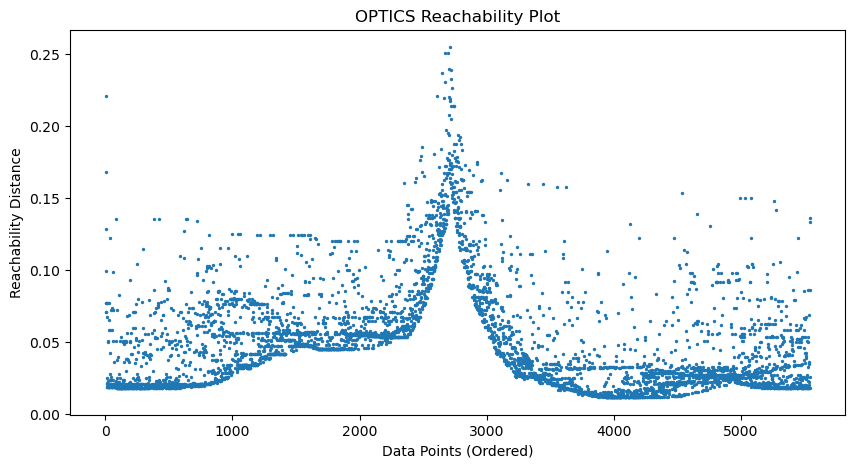

Runtime for optics_clustering: 15.114089 seconds


Running OPTICS:   0%|          | 0/3 [00:17<?, ?step/s]


Plot saved as: Images/optics_observations_normal_bins\optics_2006-2009_min200_maxeps1000_xi0.002.png
(7,)


Running OPTICS:   0%|          | 0/3 [00:00<?, ?step/s]

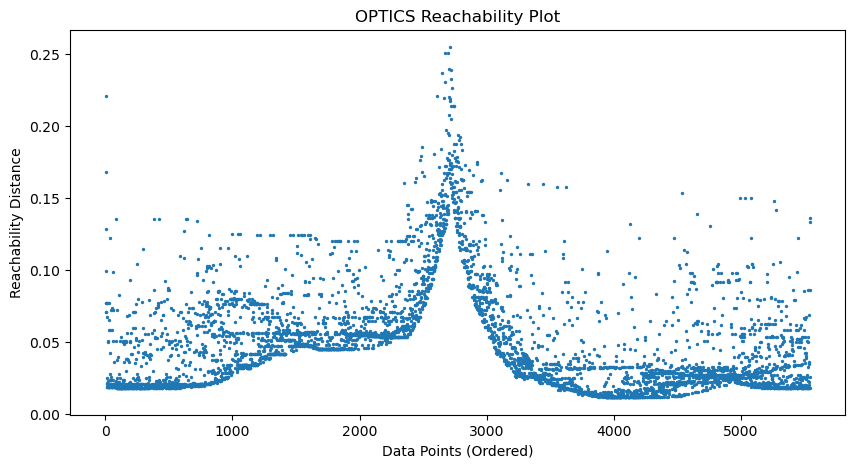

Runtime for optics_clustering: 14.410628 seconds


Running OPTICS:   0%|          | 0/3 [00:16<?, ?step/s]


Plot saved as: Images/optics_observations_normal_bins\optics_2006-2009_min200_maxepsinf_xi0.001.png
(7,)


Running OPTICS:   0%|          | 0/3 [00:00<?, ?step/s]

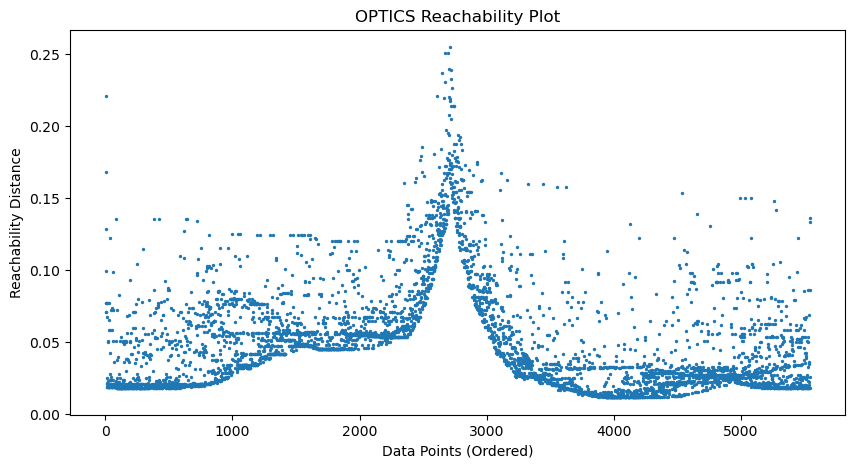

Runtime for optics_clustering: 12.188990 seconds


Running OPTICS:   0%|          | 0/3 [00:14<?, ?step/s]


Plot saved as: Images/optics_observations_normal_bins\optics_2006-2009_min200_maxepsinf_xi0.002.png
(7,)


Running OPTICS:   0%|          | 0/3 [00:00<?, ?step/s]

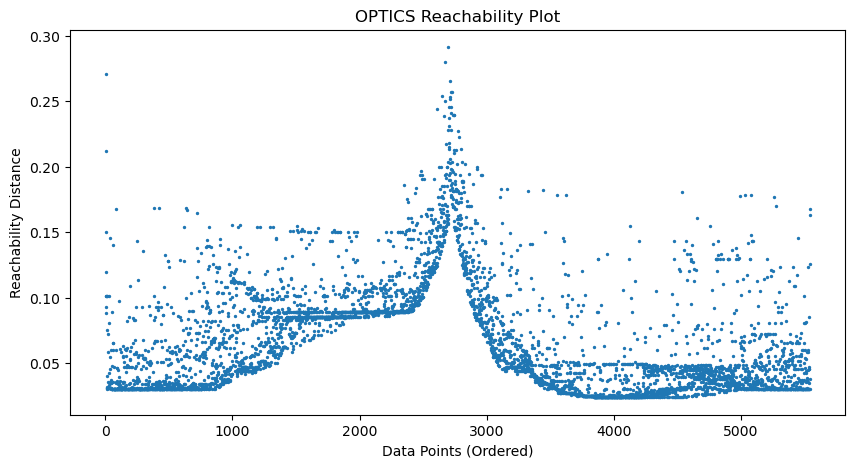

Runtime for optics_clustering: 10.985426 seconds


Running OPTICS:   0%|          | 0/3 [00:11<?, ?step/s]


Plot saved as: Images/optics_observations_normal_bins\optics_2006-2009_min400_maxeps1000_xi0.001.png
(7,)


Running OPTICS:   0%|          | 0/3 [00:00<?, ?step/s]

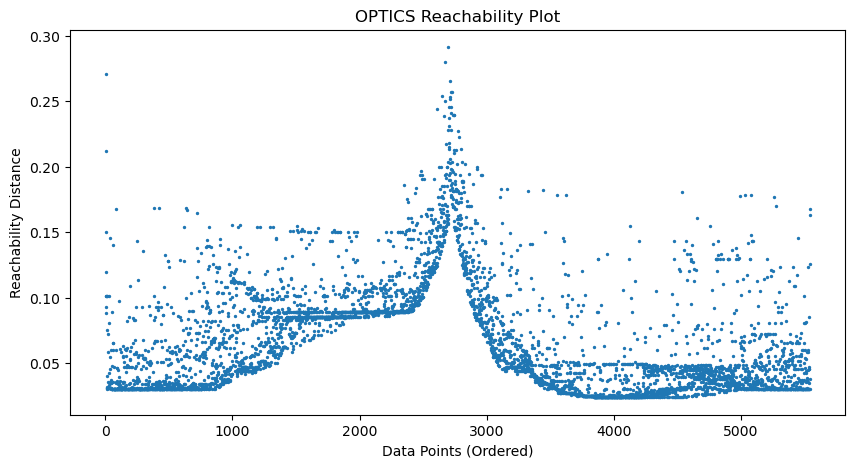

Runtime for optics_clustering: 5.873026 seconds


Running OPTICS:   0%|          | 0/3 [00:06<?, ?step/s]


Plot saved as: Images/optics_observations_normal_bins\optics_2006-2009_min400_maxeps1000_xi0.002.png
(7,)


Running OPTICS:   0%|          | 0/3 [00:00<?, ?step/s]

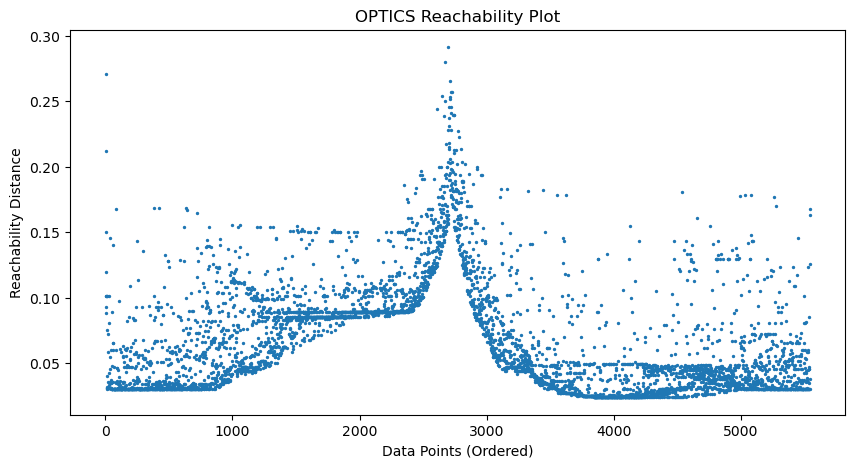

Runtime for optics_clustering: 5.801823 seconds


Running OPTICS:   0%|          | 0/3 [00:06<?, ?step/s]


Plot saved as: Images/optics_observations_normal_bins\optics_2006-2009_min400_maxepsinf_xi0.001.png
(7,)


Running OPTICS:   0%|          | 0/3 [00:00<?, ?step/s]

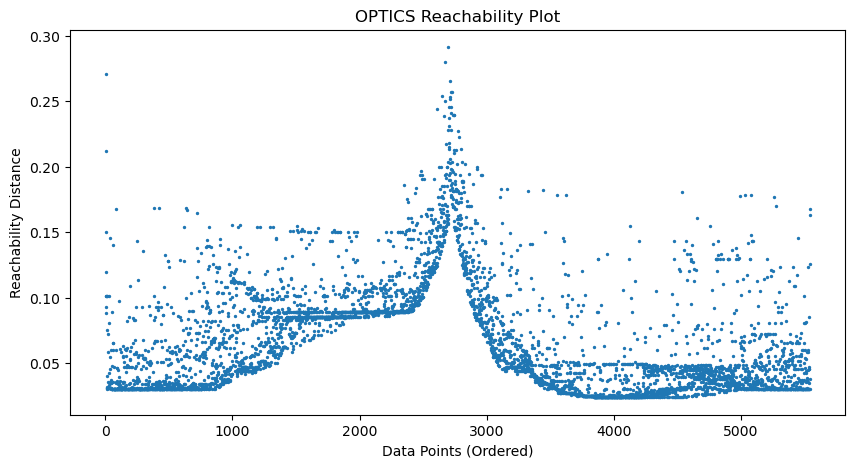

Runtime for optics_clustering: 17.962562 seconds


Running OPTICS:   0%|          | 0/3 [00:20<?, ?step/s]


Plot saved as: Images/optics_observations_normal_bins\optics_2006-2009_min400_maxepsinf_xi0.002.png
(7,)


Running OPTICS:   0%|          | 0/3 [00:00<?, ?step/s]

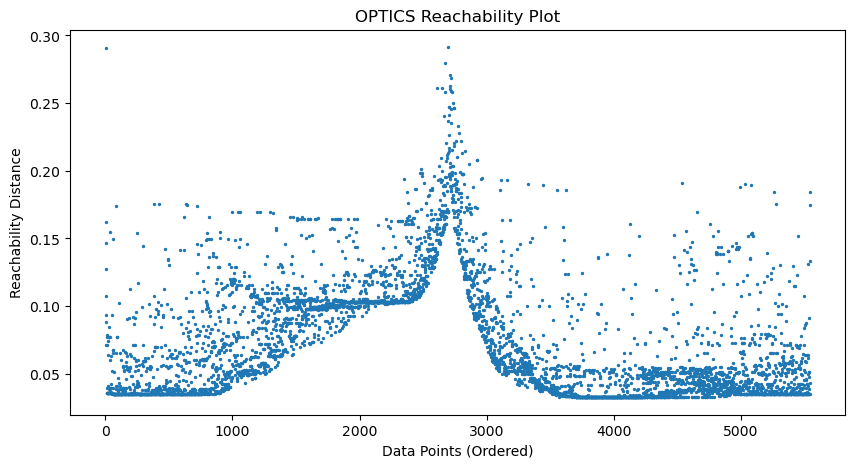

Runtime for optics_clustering: 15.853418 seconds


Running OPTICS:   0%|          | 0/3 [00:18<?, ?step/s]


Plot saved as: Images/optics_observations_normal_bins\optics_2006-2009_min500_maxeps1000_xi0.001.png
(7,)


Running OPTICS:   0%|          | 0/3 [00:00<?, ?step/s]

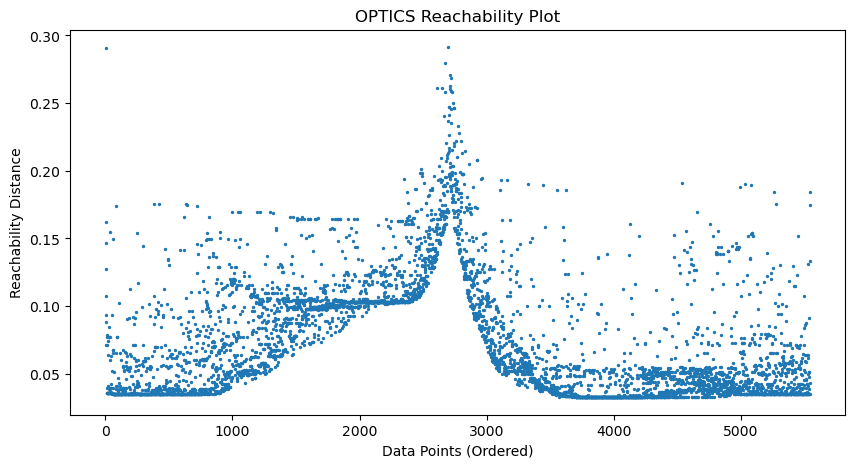

Runtime for optics_clustering: 16.311159 seconds


Running OPTICS:   0%|          | 0/3 [00:18<?, ?step/s]


Plot saved as: Images/optics_observations_normal_bins\optics_2006-2009_min500_maxeps1000_xi0.002.png
(7,)


Running OPTICS:   0%|          | 0/3 [00:00<?, ?step/s]

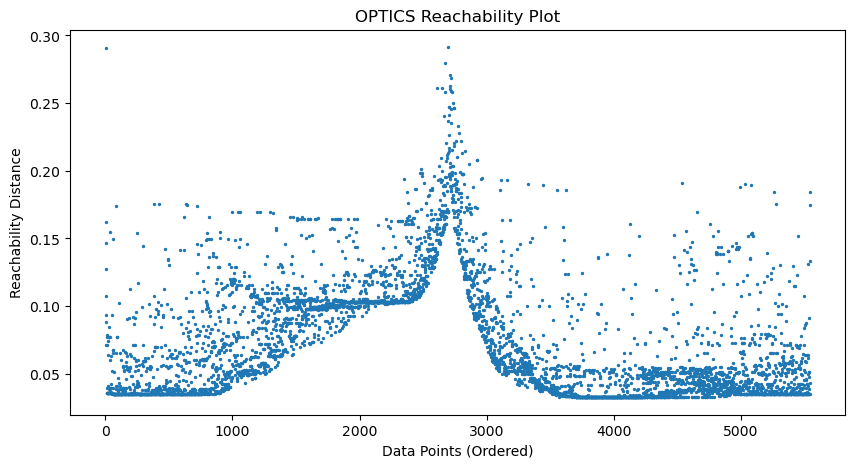

Runtime for optics_clustering: 15.434995 seconds


Running OPTICS:   0%|          | 0/3 [00:17<?, ?step/s]


Plot saved as: Images/optics_observations_normal_bins\optics_2006-2009_min500_maxepsinf_xi0.001.png
(7,)


Running OPTICS:   0%|          | 0/3 [00:00<?, ?step/s]

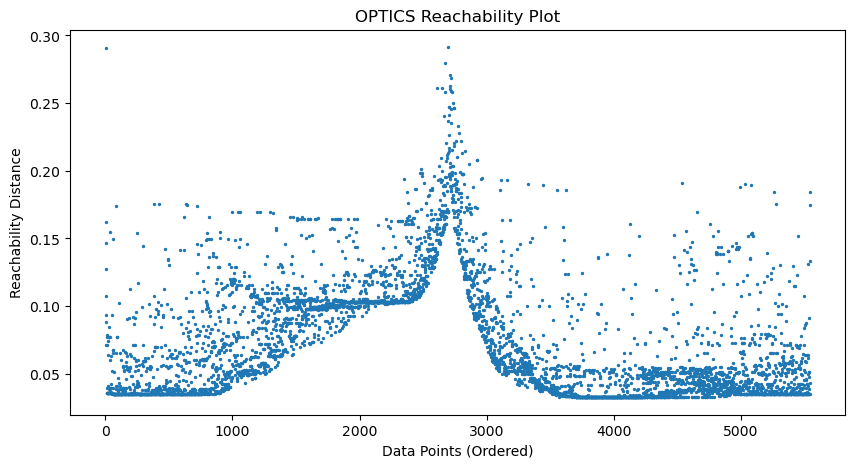

Runtime for optics_clustering: 15.075722 seconds


Running OPTICS:   0%|          | 0/3 [00:16<?, ?step/s]


Plot saved as: Images/optics_observations_normal_bins\optics_2006-2009_min500_maxepsinf_xi0.002.png
(7,)


,Year Range,k,Runtime (s),Clusters,Points per Cluster,Davies-Bouldin,Calinski-Harabasz,Dunn Index,Silhouette Score,Cluster Std.,Square Density,Hull Density
0,2006-2009,5,10.136,5,"{0: 411, 1: 1054, 2: 424, 3: 231, -1: 3425}",1.994,271.731,0.001,-0.089,"{-1: (0.173, 0.228), 0: (0.013, 0.016), 1: (0....","{-1: 3425.0, 0: 97363.56, 1: 52622.862, 2: 118...","{-1: 3518.302, 0: 133802.303, 1: 73469.063, 2:..."
1,2006-2009,5,15.114,5,"{0: 400, 1: 1054, 2: 424, 3: 231, -1: 3436}",1.989,269.987,0.001,-0.092,"{-1: (0.173, 0.228), 0: (0.012, 0.016), 1: (0....","{-1: 3436.0, 0: 101753.076, 1: 52622.862, 2: 1...","{-1: 3529.602, 0: 139825.176, 1: 73469.063, 2:..."
2,2006-2009,5,14.411,5,"{0: 411, 1: 1054, 2: 424, 3: 231, -1: 3425}",1.994,271.731,0.001,-0.089,"{-1: (0.173, 0.228), 0: (0.013, 0.016), 1: (0....","{-1: 3425.0, 0: 97363.56, 1: 52622.862, 2: 118...","{-1: 3518.302, 0: 133802.303, 1: 73469.063, 2:..."
3,2006-2009,5,12.189,5,"{0: 400, 1: 1054, 2: 424, 3: 231, -1: 3436}",1.989,269.987,0.001,-0.092,"{-1: (0.173, 0.228), 0: (0.012, 0.016), 1: (0....","{-1: 3436.0, 0: 101753.076, 1: 52622.862, 2: 1...","{-1: 3529.602, 0: 139825.176, 1: 73469.063, 2:..."
4,2006-2009,3,10.985,3,"{0: 1372, 1: 1292, -1: 2881}",2.019,589.202,0.001,-0.042,"{-1: (0.192, 0.24), 0: (0.036, 0.046), 1: (0.0...","{-1: 2881.0, 0: 36142.396, 1: 30737.524}","{-1: 2959.483, 0: 45301.767, 1: 39827.409}"
5,2006-2009,3,5.873,3,"{0: 1372, 1: 1292, -1: 2881}",2.019,589.202,0.001,-0.042,"{-1: (0.192, 0.24), 0: (0.036, 0.046), 1: (0.0...","{-1: 2881.0, 0: 36142.396, 1: 30737.524}","{-1: 2959.483, 0: 45301.767, 1: 39827.409}"
6,2006-2009,3,5.802,3,"{0: 1372, 1: 1292, -1: 2881}",2.019,589.202,0.001,-0.042,"{-1: (0.192, 0.24), 0: (0.036, 0.046), 1: (0.0...","{-1: 2881.0, 0: 36142.396, 1: 30737.524}","{-1: 2959.483, 0: 45301.767, 1: 39827.409}"
7,2006-2009,3,17.963,3,"{0: 1372, 1: 1292, -1: 2881}",2.019,589.202,0.001,-0.042,"{-1: (0.192, 0.24), 0: (0.036, 0.046), 1: (0.0...","{-1: 2881.0, 0: 36142.396, 1: 30737.524}","{-1: 2959.483, 0: 45301.767, 1: 39827.409}"
8,2006-2009,3,15.853,3,"{0: 1445, 1: 1304, -1: 2796}",1.979,621.321,0.001,-0.029,"{-1: (0.193, 0.242), 0: (0.038, 0.048), 1: (0....","{-1: 2796.0, 0: 34008.34, 1: 29435.167}","{-1: 2872.167, 0: 43873.903, 1: 37617.504}"
9,2006-2009,3,16.311,3,"{0: 1445, 1: 1304, -1: 2796}",1.979,621.321,0.001,-0.029,"{-1: (0.193, 0.242), 0: (0.038, 0.048), 1: (0....","{-1: 2796.0, 0: 34008.34, 1: 29435.167}","{-1: 2872.167, 0: 43873.903, 1: 37617.504}"



Running OPTICS for Year Range: 2010-2013


Running OPTICS:   0%|          | 0/3 [00:00<?, ?step/s]

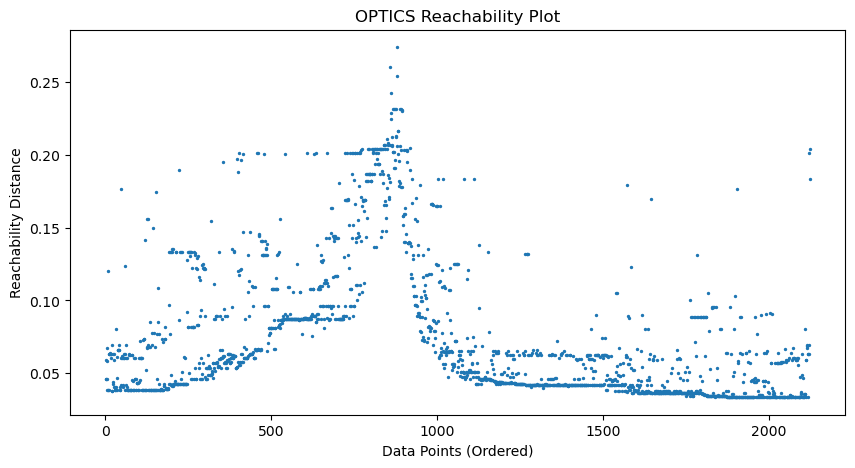

Runtime for optics_clustering: 6.139781 seconds


Running OPTICS:   0%|          | 0/3 [00:06<?, ?step/s]


Plot saved as: Images/optics_observations_normal_bins\optics_2010-2013_min200_maxeps1000_xi0.001.png
(7,)


Running OPTICS:   0%|          | 0/3 [00:00<?, ?step/s]

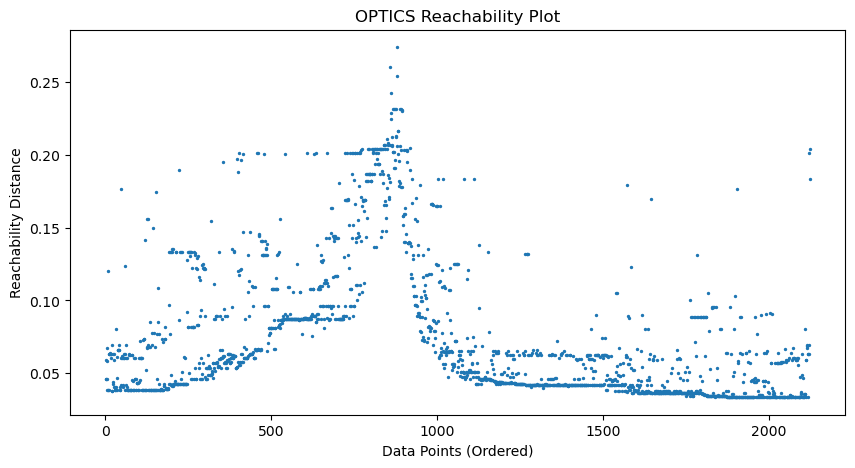

Running OPTICS:   0%|          | 0/3 [00:03<?, ?step/s]

Runtime for optics_clustering: 3.254344 seconds


Plot saved as: Images/optics_observations_normal_bins\optics_2010-2013_min200_maxeps1000_xi0.002.png
(7,)


Running OPTICS:   0%|          | 0/3 [00:00<?, ?step/s]

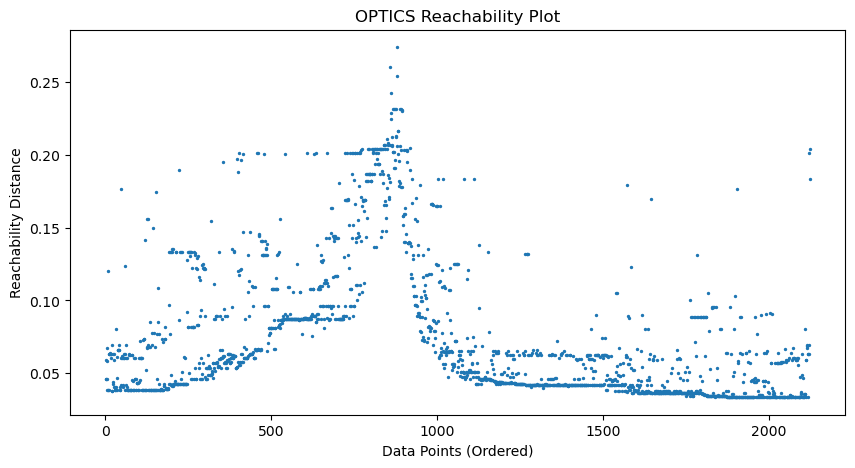

Running OPTICS:   0%|          | 0/3 [00:02<?, ?step/s]

Runtime for optics_clustering: 2.724389 seconds


Plot saved as: Images/optics_observations_normal_bins\optics_2010-2013_min200_maxepsinf_xi0.001.png
(7,)


Running OPTICS:   0%|          | 0/3 [00:00<?, ?step/s]

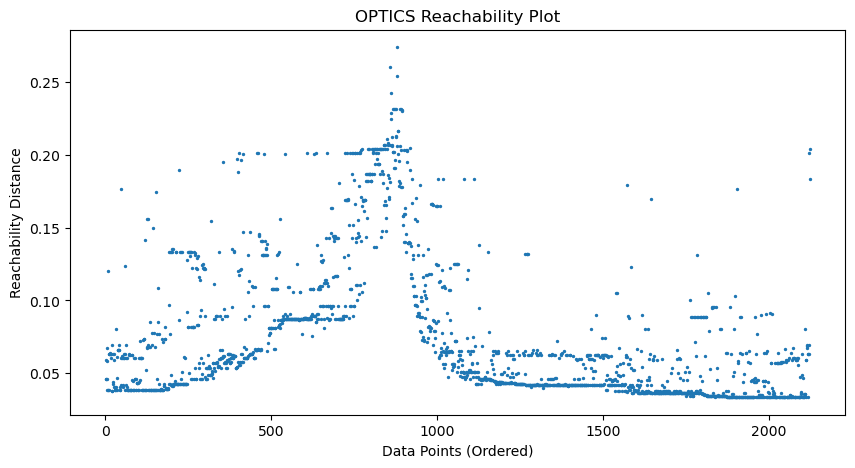

Running OPTICS:   0%|          | 0/3 [00:02<?, ?step/s]

Runtime for optics_clustering: 2.351454 seconds


Plot saved as: Images/optics_observations_normal_bins\optics_2010-2013_min200_maxepsinf_xi0.002.png
(7,)


Running OPTICS:   0%|          | 0/3 [00:00<?, ?step/s]

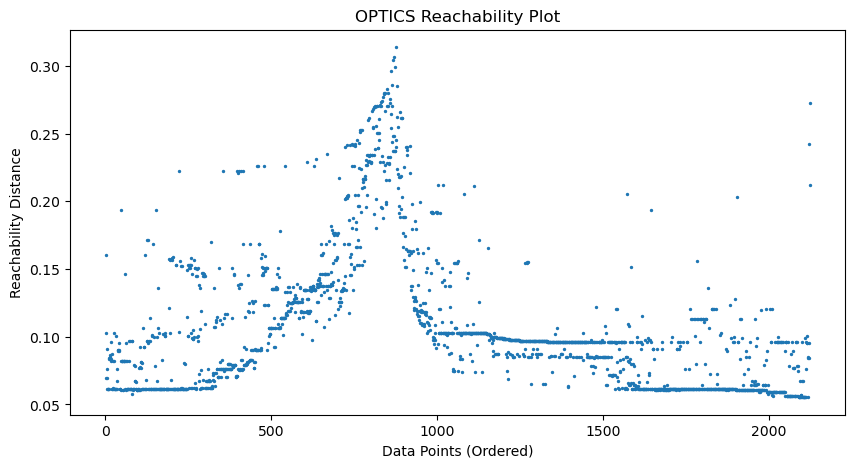

Running OPTICS:   0%|          | 0/3 [00:02<?, ?step/s]

Runtime for optics_clustering: 2.422543 seconds


Plot saved as: Images/optics_observations_normal_bins\optics_2010-2013_min400_maxeps1000_xi0.001.png
(7,)


Running OPTICS:   0%|          | 0/3 [00:00<?, ?step/s]

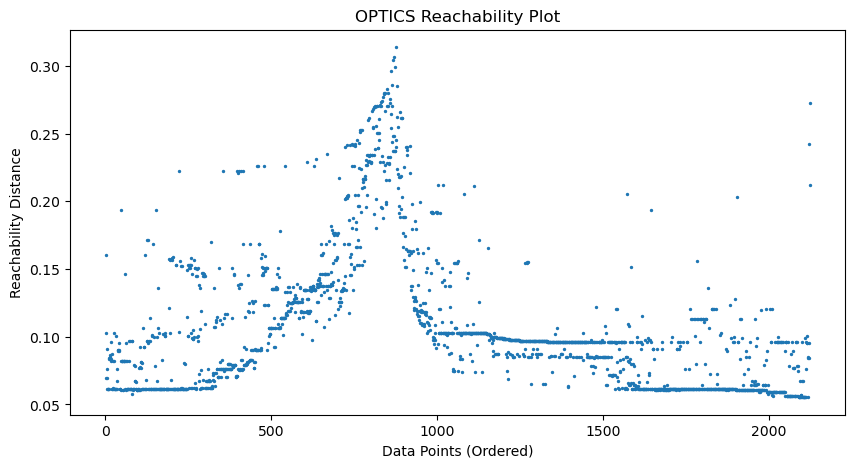

Running OPTICS:   0%|          | 0/3 [00:02<?, ?step/s]

Runtime for optics_clustering: 2.014080 seconds


Plot saved as: Images/optics_observations_normal_bins\optics_2010-2013_min400_maxeps1000_xi0.002.png
(7,)


Running OPTICS:   0%|          | 0/3 [00:00<?, ?step/s]

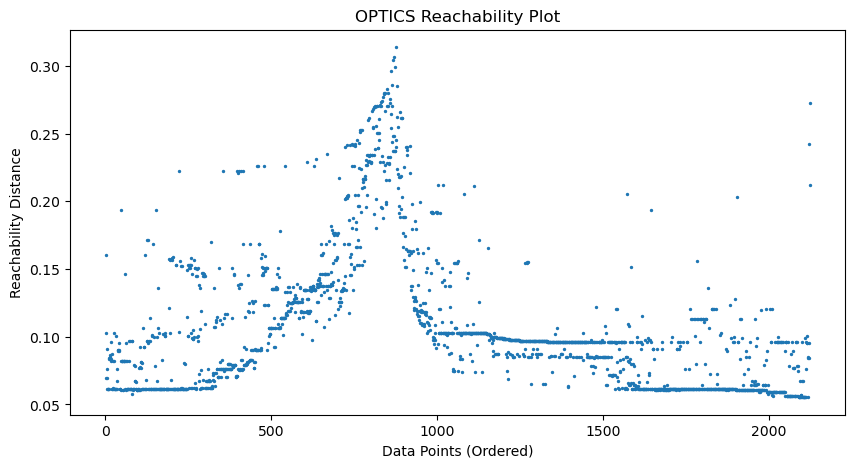

Running OPTICS:   0%|          | 0/3 [00:02<?, ?step/s]

Runtime for optics_clustering: 2.120529 seconds


Plot saved as: Images/optics_observations_normal_bins\optics_2010-2013_min400_maxepsinf_xi0.001.png
(7,)


Running OPTICS:   0%|          | 0/3 [00:00<?, ?step/s]

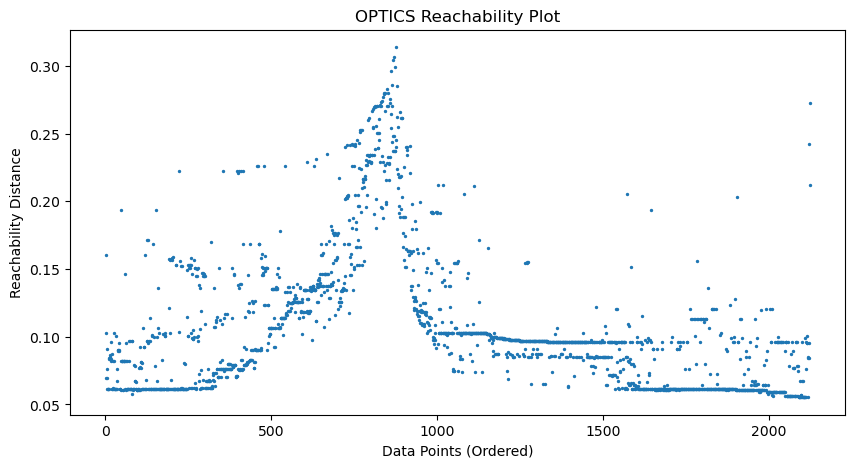

Running OPTICS:   0%|          | 0/3 [00:02<?, ?step/s]

Runtime for optics_clustering: 2.324284 seconds


Plot saved as: Images/optics_observations_normal_bins\optics_2010-2013_min400_maxepsinf_xi0.002.png
(7,)


Running OPTICS:   0%|          | 0/3 [00:00<?, ?step/s]

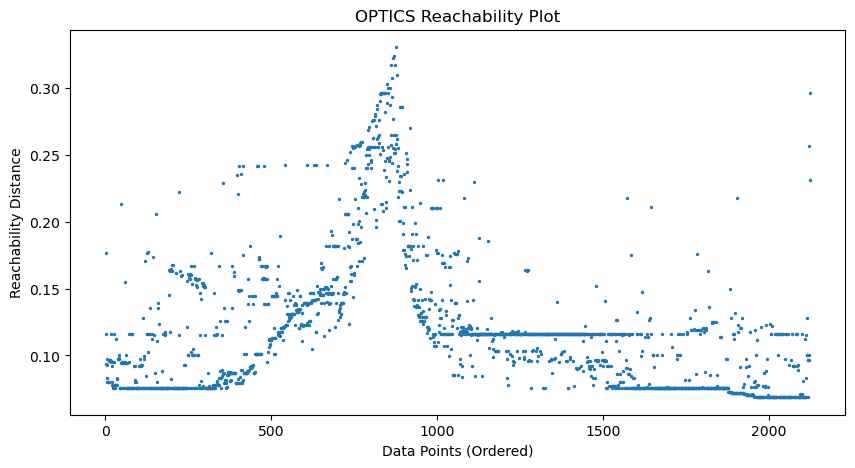

Runtime for optics_clustering: 4.461337 seconds


Running OPTICS:   0%|          | 0/3 [00:04<?, ?step/s]


Plot saved as: Images/optics_observations_normal_bins\optics_2010-2013_min500_maxeps1000_xi0.001.png
(7,)


Running OPTICS:   0%|          | 0/3 [00:00<?, ?step/s]

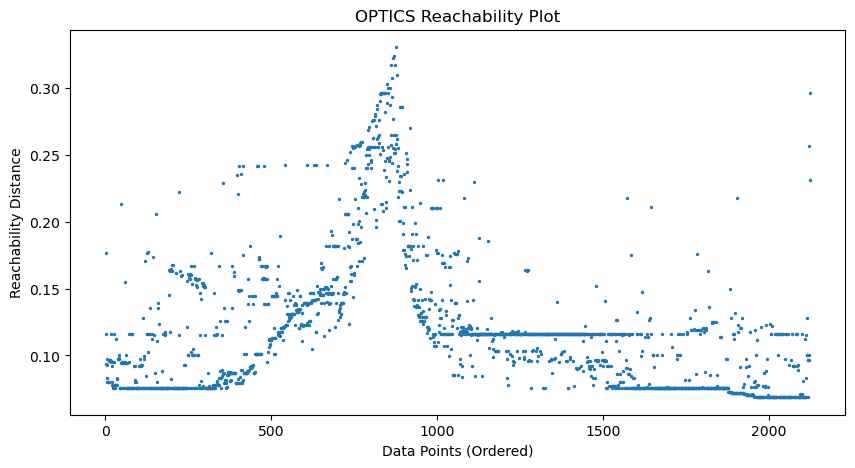

Runtime for optics_clustering: 5.942218 seconds


Running OPTICS:   0%|          | 0/3 [00:06<?, ?step/s]


Plot saved as: Images/optics_observations_normal_bins\optics_2010-2013_min500_maxeps1000_xi0.002.png
(7,)


Running OPTICS:   0%|          | 0/3 [00:00<?, ?step/s]

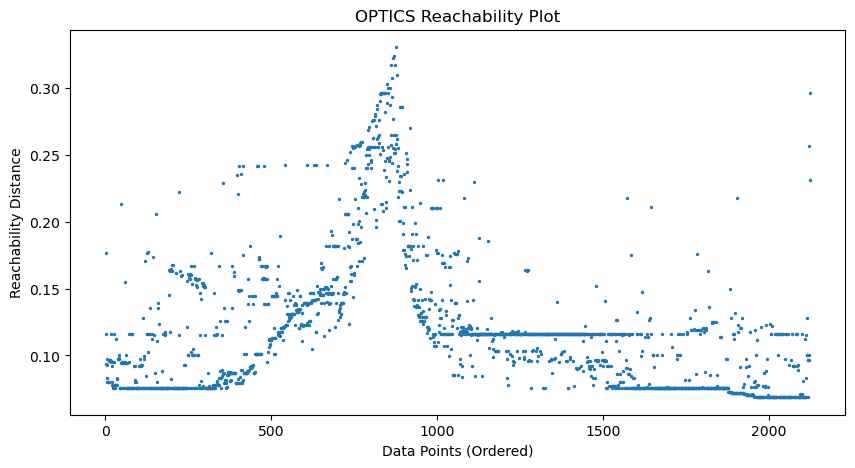

Running OPTICS:   0%|          | 0/3 [00:03<?, ?step/s]

Runtime for optics_clustering: 3.890923 seconds


Plot saved as: Images/optics_observations_normal_bins\optics_2010-2013_min500_maxepsinf_xi0.001.png
(7,)


Running OPTICS:   0%|          | 0/3 [00:00<?, ?step/s]

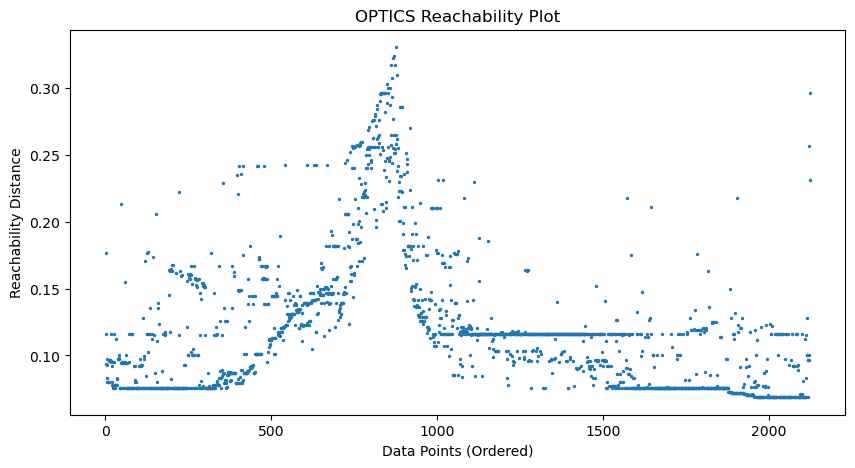

Running OPTICS:   0%|          | 0/3 [00:02<?, ?step/s]

Runtime for optics_clustering: 2.361585 seconds


Plot saved as: Images/optics_observations_normal_bins\optics_2010-2013_min500_maxepsinf_xi0.002.png
(7,)


,Year Range,k,Runtime (s),Clusters,Points per Cluster,Davies-Bouldin,Calinski-Harabasz,Dunn Index,Silhouette Score,Cluster Std.,Square Density,Hull Density
0,2010-2013,3,6.140,3,"{0: 899, 1: 458, -1: 767}",1.980,419.719,0.003,0.090,"{-1: (0.197, 0.278), 0: (0.054, 0.071), 1: (0....","{-1: 767.0, 0: 10298.551, 1: 9056.512}","{-1: 853.035, 0: 15085.937, 1: 10738.002}"
1,2010-2013,3,3.254,3,"{0: 899, 1: 458, -1: 767}",1.980,419.719,0.003,0.090,"{-1: (0.197, 0.278), 0: (0.054, 0.071), 1: (0....","{-1: 767.0, 0: 10298.551, 1: 9056.512}","{-1: 853.035, 0: 15085.937, 1: 10738.002}"
2,2010-2013,3,2.724,3,"{0: 899, 1: 458, -1: 767}",1.980,419.719,0.003,0.090,"{-1: (0.197, 0.278), 0: (0.054, 0.071), 1: (0....","{-1: 767.0, 0: 10298.551, 1: 9056.512}","{-1: 853.035, 0: 15085.937, 1: 10738.002}"
3,2010-2013,3,2.351,3,"{0: 899, 1: 458, -1: 767}",1.980,419.719,0.003,0.090,"{-1: (0.197, 0.278), 0: (0.054, 0.071), 1: (0....","{-1: 767.0, 0: 10298.551, 1: 9056.512}","{-1: 853.035, 0: 15085.937, 1: 10738.002}"
4,2010-2013,2,2.423,2,"{0: 989, -1: 1135}",1.265,731.241,0.000,0.024,"{-1: (0.18, 0.221), 0: (0.059, 0.081)}","{-1: 1135.0, 0: 7387.864}","{-1: 1262.314, 0: 9525.071}"
5,2010-2013,2,2.014,2,"{0: 980, -1: 1144}",1.259,729.444,0.000,0.023,"{-1: (0.179, 0.221), 0: (0.059, 0.079)}","{-1: 1144.0, 0: 7475.833}","{-1: 1272.324, 0: 9523.244}"
6,2010-2013,2,2.121,2,"{0: 989, -1: 1135}",1.265,731.241,0.000,0.024,"{-1: (0.18, 0.221), 0: (0.059, 0.081)}","{-1: 1135.0, 0: 7387.864}","{-1: 1262.314, 0: 9525.071}"
7,2010-2013,2,2.324,2,"{0: 980, -1: 1144}",1.259,729.444,0.000,0.023,"{-1: (0.179, 0.221), 0: (0.059, 0.079)}","{-1: 1144.0, 0: 7475.833}","{-1: 1272.324, 0: 9523.244}"
8,2010-2013,2,4.461,2,"{0: 1041, -1: 1083}",1.328,707.093,0.000,0.024,"{-1: (0.183, 0.225), 0: (0.061, 0.087)}","{-1: 1083.0, 0: 6759.537}","{-1: 1204.481, 0: 9188.762}"
9,2010-2013,2,5.942,2,"{0: 1041, -1: 1083}",1.328,707.093,0.000,0.024,"{-1: (0.183, 0.225), 0: (0.061, 0.087)}","{-1: 1083.0, 0: 6759.537}","{-1: 1204.481, 0: 9188.762}"



Running OPTICS for Year Range: 2014-2017


Running OPTICS:   0%|          | 0/3 [00:00<?, ?step/s]

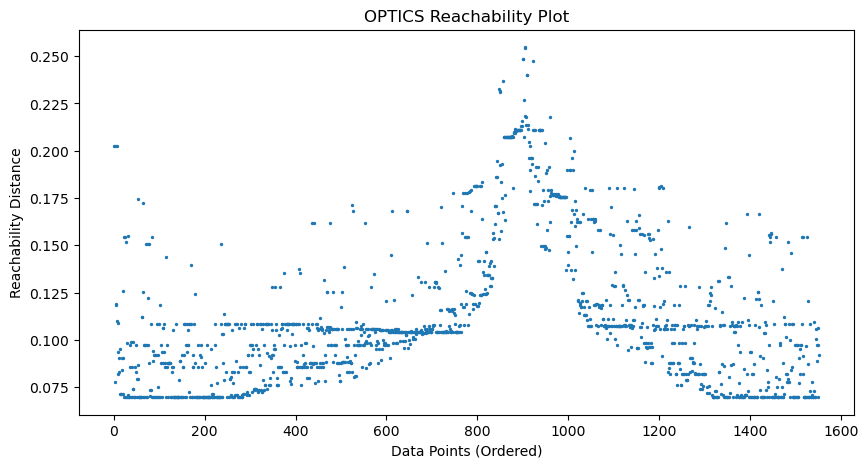

Running OPTICS:   0%|          | 0/3 [00:02<?, ?step/s]

Runtime for optics_clustering: 2.390820 seconds


Plot saved as: Images/optics_observations_normal_bins\optics_2014-2017_min200_maxeps1000_xi0.001.png
(7,)


Running OPTICS:   0%|          | 0/3 [00:00<?, ?step/s]

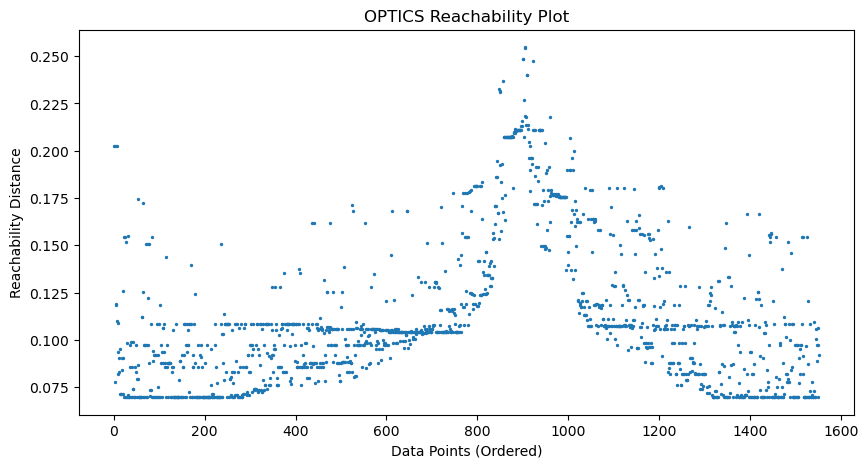

Running OPTICS:   0%|          | 0/3 [00:01<?, ?step/s]

Runtime for optics_clustering: 1.462259 seconds


Plot saved as: Images/optics_observations_normal_bins\optics_2014-2017_min200_maxeps1000_xi0.002.png
(7,)


Running OPTICS:   0%|          | 0/3 [00:00<?, ?step/s]

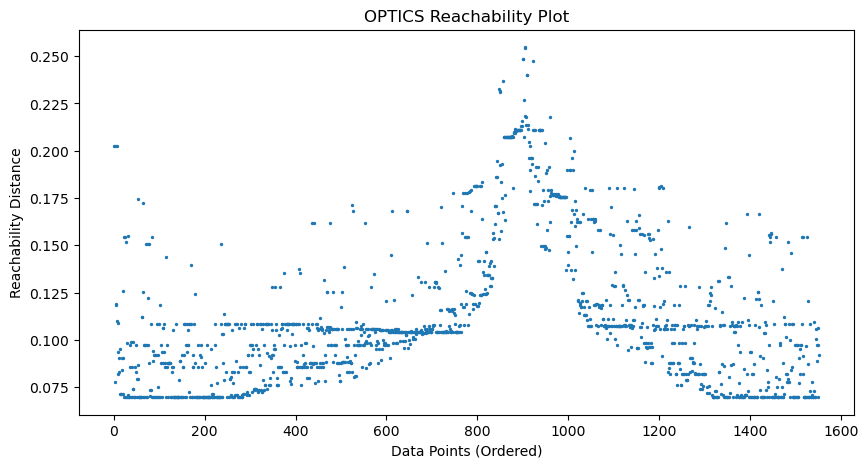

Running OPTICS:   0%|          | 0/3 [00:01<?, ?step/s]

Runtime for optics_clustering: 1.774855 seconds


Plot saved as: Images/optics_observations_normal_bins\optics_2014-2017_min200_maxepsinf_xi0.001.png
(7,)


Running OPTICS:   0%|          | 0/3 [00:00<?, ?step/s]

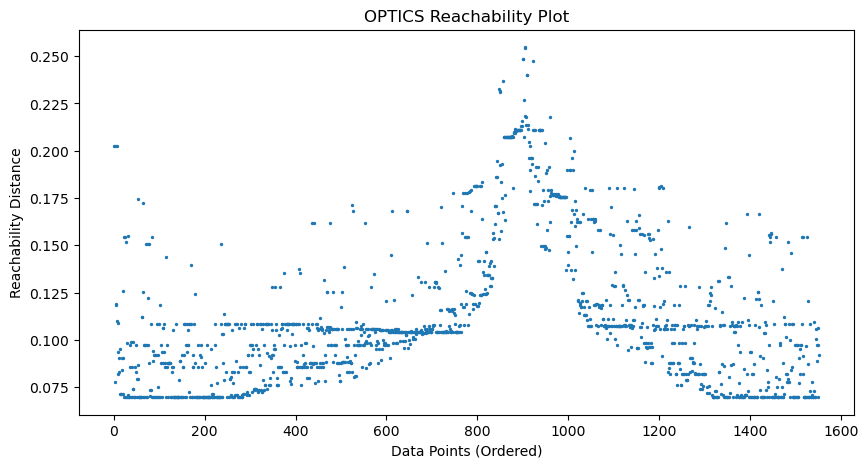

Running OPTICS:   0%|          | 0/3 [00:02<?, ?step/s]

Runtime for optics_clustering: 2.252420 seconds


Plot saved as: Images/optics_observations_normal_bins\optics_2014-2017_min200_maxepsinf_xi0.002.png
(7,)


Running OPTICS:   0%|          | 0/3 [00:00<?, ?step/s]

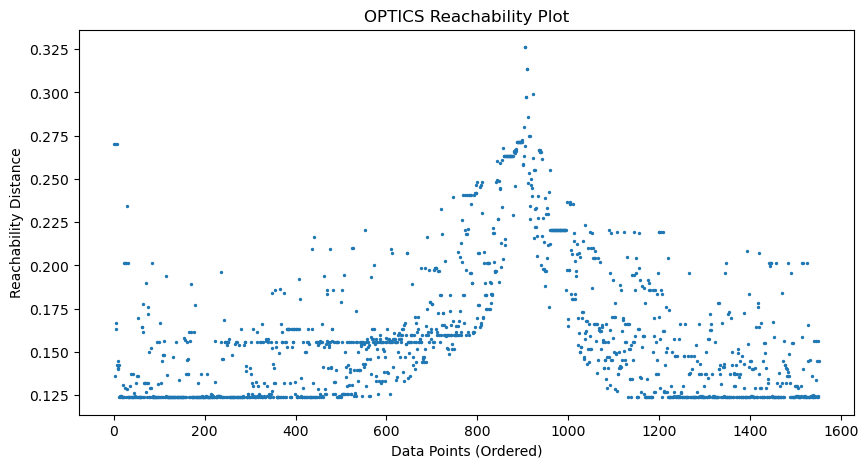

Running OPTICS:   0%|          | 0/3 [00:01<?, ?step/s]

Runtime for optics_clustering: 1.876109 seconds


Plot saved as: Images/optics_observations_normal_bins\optics_2014-2017_min400_maxeps1000_xi0.001.png
(0,)


AttributeError: 'numpy.int32' object has no attribute 'items'

In [ ]:
import cluster_data
from cluster_data import run_clustering, normalize_data, unnormalize
import numpy as np
import pandas as pd
import os
import cluster_plotter
from OPTICS import optics_clustering
from cluster_plotter import ClusterPlotter
from clustering_utils import ClusterData

# Define observed files
uncorr_obs_files = {
    year: f"ogs{year}01_12_det.ele_ucorr" if year != 2002 else f"ogs{year}08_12_det.ele_ucorr"
    for year in range(2002, 2024) if year != 2018  # Exclude 2018 if missing
}

print(uncorr_obs_files)

standard_year_ranges = {f"{start}-{start + 3}": np.arange(start, start + 4) for start in [2002, 2006, 2010, 2014]}
standard_year_ranges["2019-2023"] = np.arange(2019, 2024)

running_ranges = cluster_data.generate_running_year_ranges(2002, 2023, 4)
year_ranges = standard_year_ranges

# Bin the observed data
binned_data = cluster_data.bin_observed_data(uncorr_obs_files, year_ranges, print_res=False)
results_per_year_range = {}

plot_dir = "Images/optics_observations_normal_bins"
os.makedirs(plot_dir, exist_ok=True)
cluster_plotter.clear_directory(plot_dir)

for cluster_data, year_range in binned_data:  
    print(f"\nRunning OPTICS for Year Range: {year_range}")

    data_array = np.array([cluster_data.inc, cluster_data.raan]).T
    normalized_data, data_min, data_max = normalize_data(data_array)

    min_samples_values = [200, 400, 500]
    max_eps_vals = [1000, np.inf]
    xi_vals = [0.001, 0.002]

    results = []

    for min_sample in min_samples_values: 
        for max_eps in max_eps_vals:
            for xi in xi_vals:
                result_optics, time_optics, n_clusters_optics, points_per_cluster_optics, metrics_optics = run_clustering(
                    optics_clustering, "OPTICS", normalized_data, data_min, data_max, min_samples = min_sample, max_eps = max_eps, xi = xi, plot_reachability = True, plot=False
                )

                unnormalized_data, cluster_centers = unnormalize(
                    result_optics.data, result_optics.cluster_centers, data_min, data_max
                )
                plotter = ClusterPlotter(unnormalized_data, result_optics.labels, cluster_centers)
                plot_filename = os.path.join(plot_dir, f"optics_{year_range}_min{min_sample}_maxeps{max_eps}_xi{xi}.png")
                title = f"OPTICS: years = {year_range}, min: {min_sample}, maxeps: {max_eps}, xi: {xi},"
                plotter.clusters_2d_plot(title, plot_filename)

                # Round metric results
                print(np.array(metrics_optics).shape)
                if np.array(metrics_optics).shape == (0,):
                # Assign worst possible values (e.g., np.inf or large numbers for various metrics)
                    metrics_optics = np.array([0, 0, 0, 0, 0, 0, 0])

                # Safely round the values of metrics_optics[4], metrics_optics[5], and metrics_optics[6] if they are dictionary-like
                rounded_cluster_std = {
                    key: tuple(round(val, 3) for val in value) 
                    for key, value in (metrics_optics[4].items() if isinstance(metrics_optics[4], dict) else {}).items()
                } if isinstance(metrics_optics[4], dict) else None

                rounded_square_density = {
                    key: round(value, 3) 
                    for key, value in (metrics_optics[5].items() if isinstance(metrics_optics[5], dict) else {}).items()
                } if isinstance(metrics_optics[5], dict) else None

                rounded_hull_density = {
                    key: round(value, 3) 
                    for key, value in (metrics_optics[6].items() if isinstance(metrics_optics[6], dict) else {}).items()
                } if isinstance(metrics_optics[6], dict) else None


                results.append({
                    "Year Range": year_range,
                    "k": n_clusters_optics,
                    "Runtime (s)": f"{time_optics:.3f}",
                    "Clusters": n_clusters_optics,
                    "Points per Cluster": points_per_cluster_optics,
                    "Davies-Bouldin": f"{metrics_optics[0]:.3f}" if metrics_optics and isinstance(metrics_optics[0], (int, float)) else None,
                    "Calinski-Harabasz": f"{metrics_optics[1]:.3f}" if metrics_optics and isinstance(metrics_optics[1], (int, float)) else None,
                    "Dunn Index": f"{metrics_optics[2]:.3f}" if metrics_optics and isinstance(metrics_optics[2], (int, float)) else None,
                    "Silhouette Score": f"{metrics_optics[3]:.3f}" if metrics_optics and isinstance(metrics_optics[3], (int, float)) else None,
                    "Cluster Std.": rounded_cluster_std if rounded_cluster_std else None,
                    "Square Density": rounded_square_density if rounded_square_density else None,
                    "Hull Density": rounded_hull_density if rounded_hull_density else None
                })

    df = pd.DataFrame(results)
    display(df)

## Observed data, clustering with HDBSCAN

In [ ]:
import cluster_data
from cluster_data import run_clustering, normalize_data, unnormalize
import numpy as np
import pandas as pd
import os
import cluster_plotter
from HDBSCAN import hdbscan_clustering
from cluster_plotter import ClusterPlotter
from clustering_utils import ClusterData

uncorr_obs_files = {
    year: f"ogs{year}01_12_det.ele_ucorr" if year != 2002 else f"ogs{year}08_12_det.ele_ucorr"
    for year in range(2002, 2024) if year != 2018  # Exclude 2018 if missing
}

print(uncorr_obs_files)

standard_year_ranges = {f"{start}-{start + 3}": np.arange(start, start + 4) for start in [2002, 2006, 2010, 2014]}
standard_year_ranges["2019-2023"] = np.arange(2019, 2024)

running_ranges = cluster_data.generate_running_year_ranges(2002, 2023, 4)
year_ranges = standard_year_ranges

binned_data = cluster_data.bin_observed_data(uncorr_obs_files, year_ranges, print_res=False)

results_per_year_range = {}

images_dir = "Images"
os.makedirs(images_dir, exist_ok=True)
plot_dir = os.path.join("Images", "hdbscan_observations_normal_bins")
os.makedirs(plot_dir, exist_ok=True)
cluster_plotter.clear_directory(plot_dir)

for cluster_data, year_range in binned_data:  
    print(f"\nRunning HDBSCAN for Year Range: {year_range}")

    data_array = np.array([cluster_data.inc, cluster_data.raan]).T
    normalized_data, data_min, data_max = normalize_data(data_array)

    min_cluster_size_values = [100, 150, 180]  
    min_samples_values = [None, 5, 10] 
    cluster_selection_epsilon_values = [0.0, 0.01, 0.1] 

    results = []

    for min_cluster_size in min_cluster_size_values: 
        for min_samples in min_samples_values:
            for cluster_selection_epsilon in cluster_selection_epsilon_values:

                result_hdbscan, time_hdbscan, n_clusters_hdbscan, points_per_cluster_hdbscan, metrics_hdbscan = run_clustering(
                    hdbscan_clustering, "HDBSCAN", normalized_data, data_min, data_max, min_cluster_size = min_cluster_size, min_samples = min_samples, cluster_selection_epsilon = cluster_selection_epsilon, plot_condensed_tree=True, plot=False
                )

                unnormalized_data, cluster_centers = unnormalize(
                    result_hdbscan.data, result_hdbscan.cluster_centers, data_min, data_max
                )
                plotter = ClusterPlotter(unnormalized_data, result_hdbscan.labels, cluster_centers)
                plot_filename = os.path.join(plot_dir, f"hdbscan_{year_range}_minclust{min_cluster_size}_minsamples{min_samples}_epsilon{cluster_selection_epsilon}.png")
                title = f"HDBSCAN: years = {year_range}, min_cluster_size: {min_cluster_size}, min_samples: {min_samples}, epsilon: {cluster_selection_epsilon},"
                plotter.clusters_2d_plot(title, plot_filename)

                rounded_cluster_std = {key: tuple(round(val, 3) for val in value) for key, value in metrics_hdbscan[4].items()}
                rounded_square_density = {key: round(value, 3) for key, value in metrics_hdbscan[5].items()}
                rounded_hull_density = {key: round(value, 3) for key, value in metrics_hdbscan[6].items()}

                results.append({
                    "Year Range": year_range,
                    "k": n_clusters_hdbscan,
                    "Runtime (s)": f"{time_hdbscan:.3f}",
                    "Clusters": n_clusters_hdbscan,
                    "Points per Cluster": points_per_cluster_hdbscan,
                    "Davies-Bouldin": f"{metrics_hdbscan[0]:.3f}" if metrics_hdbscan and isinstance(metrics_hdbscan[0], (int, float)) else None,
                    "Calinski-Harabasz": f"{metrics_hdbscan[1]:.3f}" if metrics_hdbscan and isinstance(metrics_hdbscan[1], (int, float)) else None,
                    "Dunn Index": f"{metrics_hdbscan[2]:.3f}" if metrics_hdbscan and isinstance(metrics_hdbscan[2], (int, float)) else None,
                    "Silhouette Score": f"{metrics_hdbscan[3]:.3f}" if metrics_hdbscan and isinstance(metrics_hdbscan[3], (int, float)) else None,
                    "Cluster Std.": rounded_cluster_std if rounded_cluster_std else None,
                    "Square Density": rounded_square_density if rounded_square_density else None,
                    "Hull Density": rounded_hull_density if rounded_hull_density else None
                })

    df = pd.DataFrame(results)
    display(df)

## Observed data, clustering with DENCLUE

In [ ]:
import cluster_data
from cluster_data import run_clustering, normalize_data, unnormalize
import numpy as np
import pandas as pd
import os
import cluster_plotter
from clustering_utils import ClusteringResult
from scipy.spatial.distance import cdist
from DENCLUE import denclue_clustering  # Import DENCLUE clustering function
from cluster_plotter import ClusterPlotter

uncorr_obs_files = {
    year: f"ogs{year}01_12_det.ele_ucorr" if year != 2002 else f"ogs{year}08_12_det.ele_ucorr"
    for year in range(2002, 2024) if year != 2018  # Exclude 2018 if missing
}

print(uncorr_obs_files)

standard_year_ranges = {f"{start}-{start + 3}": np.arange(start, start + 4) for start in [2002, 2006, 2010, 2014]}
standard_year_ranges["2019-2023"] = np.arange(2019, 2024)

running_ranges = cluster_data.generate_running_year_ranges(2002, 2023, 4)
year_ranges = standard_year_ranges

binned_data = cluster_data.bin_observed_data(uncorr_obs_files, year_ranges, print_res=False)

results_per_year_range = {}

plot_dir = "Images/denclue_observations_normal_bins"
os.makedirs(plot_dir, exist_ok=True)
cluster_plotter.clear_directory(plot_dir)

for cluster_data, year_range in binned_data:  
    print(f"\nRunning DENCLUE for Year Range: {year_range}")

    data_array = np.array([cluster_data.inc, cluster_data.raan]).T
    normalized_data, data_min, data_max = normalize_data(data_array)

    epsilon_vals = [30, 40, 50]
    max_iter_vals = [100, 200, 300]
    bandwidth_vals = [0.005, 0.07, 0.01]

    results = []

    for epsilon in epsilon_vals:
        for max_iter in max_iter_vals:
            for bandwidth in bandwidth_vals:
                result_denclue, time_denclue, n_clusters_denclue, points_per_cluster_denclue, metrics_denclue = run_clustering(
                    denclue_clustering, "DENCLUE",
                    normalized_data, data_min, data_max, epsilon=epsilon, max_iter=max_iter, bandwidth=bandwidth, plot=False
                )
                if len(result_denclue.cluster_centers) > 0:
                    unnormalized_data, cluster_centers = unnormalize(
                        result_denclue.data, result_denclue.cluster_centers, data_min, data_max
                    )
                    plotter = ClusterPlotter(unnormalized_data, result_denclue.labels, None)
                    plot_filename = os.path.join(plot_dir, f"denclue_{year_range}_eps{epsilon}_maxiter{max_iter}_bandwidth{bandwidth}.png")
                    title = f"DENCLUE: years = {year_range}, epsilon: {epsilon}, max_iter: {max_iter}, bandwidth: {bandwidth}"
                    plotter.clusters_2d_plot(title, plot_filename, show_centers=False)
                    
                    rounded_cluster_std = {key: tuple(round(val, 3) for val in value) for key, value in metrics_denclue[4].items()}
                    rounded_square_density = {key: round(value, 3) for key, value in metrics_denclue[5].items()}
                    rounded_hull_density = {key: round(value, 3) for key, value in metrics_denclue[6].items()}

                    results.append({
                        "Year Range": year_range,
                        "k": n_clusters_denclue,
                        "Runtime (s)": f"{time_denclue:.3f}",
                        "Clusters": n_clusters_denclue,
                        "Points per Cluster": points_per_cluster_denclue,
                        "Davies-Bouldin": f"{metrics_denclue[0]:.3f}" if metrics_denclue and isinstance(metrics_denclue[0], (int, float)) else None,
                        "Calinski-Harabasz": f"{metrics_denclue[1]:.3f}" if metrics_denclue and isinstance(metrics_denclue[1], (int, float)) else None,
                        "Dunn Index": f"{metrics_denclue[2]:.3f}" if metrics_denclue and isinstance(metrics_denclue[2], (int, float)) else None,
                        "Silhouette Score": f"{metrics_denclue[3]:.3f}" if metrics_denclue and isinstance(metrics_denclue[3], (int, float)) else None,
                        "Cluster Std.": rounded_cluster_std if rounded_cluster_std else None,
                        "Square Density": rounded_square_density if rounded_square_density else None,
                        "Hull Density": rounded_hull_density if rounded_hull_density else None
                    })
                else:
                    print(f"No clusters formed for epsilon={epsilon}, max_iter={max_iter}, bandwidth={bandwidth}. Skipping plotting and results.")
                    continue


    df = pd.DataFrame(results)
    display(df)